<a href="https://colab.research.google.com/github/albreyes/PE-A-09/blob/main/vanilla_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pronóstico univariado a un paso usando el algoritmo Vanilla LSTM 

Una red Vanilla es un modelo LSTM que tiene una sola capa oculta y una capa de salida.

## Preparación de los datos

Antes de utilizar una serie univariada para construir un modelo de pronóstico, ésta primero se debe preparar. El algoritmo LSTM aprenderá una función que asocia una secuencia de observaciones pasadas (entrada) con una observación de salida (pronóstico). Como tal, la secuencia de observaciones debe transformarse en múltiples ejemplos de los que la celda LSTM pueda aprender.

Por ejemplo, considere una secuencia univariada simple como ésta:

\\begin{matrix}10 & 20 & 30 & 40 & 50 & 60 & 70 & 80 & 90 \\\end{matrix}

Podemos dividir la secuencia en múltiples patrones de entrada / salida (muestras), donde se usan tres pasos de tiempo como entrada y un paso de tiempo como salida para la predicción de un paso que se está aprendiendo.

\\begin{matrix}x &  &  & & y \\10 & 20 & 30 & & 40 \\20 & 30 & 40 & & 50\\30 & 40 & 50 & & 60 \\\end{matrix}

Gráficamente, se puede ver como una ventana $w$ con una secuencia de valores donde el último valor $P_1$ el un siguiente paso en el tiempo. Usándo otro ejemplo, con cuatro valores, se puede ver así:

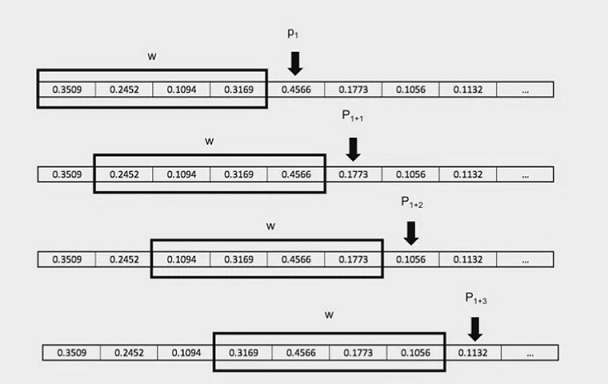

La función split_sequence() implementa este comportamiento dividiendo una secuencia univariada  en múltiples muestras, donde cada muestra tiene un número específico de pasos de tiempo y la salida es un solo paso de tiempo.

In [ ]:
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

In [ ]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

Usemos la función para el ejemplo gráfico. Queda de ejercicio, hacerlo para la secuencia de enteros.

In [ ]:
# definimos una secuencia de entrada 
secuencia_cruda = [0.3509, 0.2452, 0.1094, 0.3169, 0.4566, 0.1773, 0.1056, 0.1132]
# escogemos el número de pasos 
n_pasos = 4
# separamos en muestras del tipo X, y (donde X es un vector y y un escalar)
X, y = split_sequence(secuencia_cruda, n_pasos)
# repasamos los ejemplos para ver como quedaron
for i in range(len(X)):
	print(X[i], y[i])

[0.3509 0.2452 0.1094 0.3169] 0.4566
[0.2452 0.1094 0.3169 0.4566] 0.1773
[0.1094 0.3169 0.4566 0.1773] 0.1056
[0.3169 0.4566 0.1773 0.1056] 0.1132


Ahora sí, usémos datos reales de demanda máxima. Para esto recurriremos a una base de datos en Kaggle con datos históricos públicos de [demanda eléctrica en Australia](https://www.kaggle.com/dcervan/demanda-electrica-australia). Se trata de información mensual desde 1980 a 1995 (15 años).
Carguemos los datos desde drive.

In [ ]:
# montamos la unidad de drive en colab
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
import csv
import numpy as np

In [ ]:
data_path= 'gdrive/My Drive/INEEL/Cubico/grupo_pronostico/datos/Demanda_electricidad_mensual-2-sinFecha.csv'
#data_path= 'gdrive/My Drive/INEEL/Cubico/grupo_pronostico/datos/Demanda_electricidad_anual-sinFecha.csv'


with open(data_path, 'r') as f:
    reader = csv.reader(f, delimiter=',')
    headers = next(reader)
    raw_seq = np.array(list(reader)).astype(float)
    raw_seq = [row[0] for row in raw_seq]

Grafiquemos la serie de tiempo tal cual se encuentra en el archivo para conocer su comportamiento

Text(0, 0.5, 'Demanda (GW-h)')

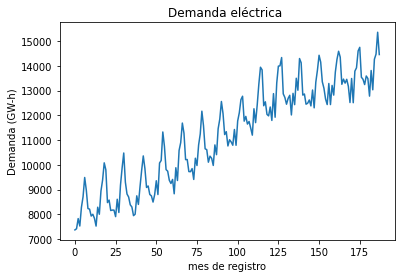

In [ ]:
import matplotlib.pyplot as plt

plt.title('Demanda eléctrica ')
plt.plot(raw_seq)
plt.xlabel('mes de registro')
plt.ylabel('Demanda (GW-h)')

Generamos los datos de entrenamiento para los datos de demanda, 

In [ ]:
# choose a number of time steps
n_steps = 3
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1

Especificamos el número de atributos o característica (1 en este caso) y ponemos los datos en formato lista de matrices.

In [ ]:
X = X.reshape((X.shape[0], X.shape[1], n_features))

Separamos los datos en datos de prueba (20%) y entrenamiento (80%).

In [ ]:
from sklearn.model_selection import train_test_split
num_test = 0.20 # aquí se está especificando 20% para test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=num_test)

Aquí es donde construimos la red recurrente. Iniciamos con un modelo secuencial al que le agregamos una celda LSTM con 50 unidades, espcificando su tipo de funcíon de activación y la forma de la entrada, en esta caso* [n_pasos,n_caracteristicas]*. Como salida usamos una capa densa con una salida (valor de pronóstico). Para la infrerencia usamos descenso de gradiente adam con métrica para convergencia usando el error mse. El entrenamiento se limita a 200 épocas.

In [ ]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
#model.fit(X, y, epochs=200, verbose=0)
model.fit(X_train, y_train, epochs=200, verbose=0)

Mostramos un resumen de las características de la red recurrente y una representación gráfica para tener mejor idea de la topología.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


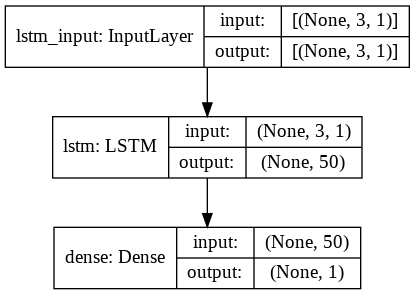

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='gdrive/My Drive/INEEL/Cubico/grupo_pronostico/datos/model_plot.png', show_shapes=True, show_layer_names=True)

Guardamos todos los valores predichos para el conjunto de prueba (solo predicciones) en una lista llamada *lista* que después compararemos con los valores reales, guardados en *y_test*.

In [ ]:
#l=X.reshape((X.shape[0],X.shape[1]))
l=X_test.reshape((X_test.shape[0],X_test.shape[1]))
lista=array([])
for i in l:
    i = i.reshape((1, n_steps, n_features))
    yhat = model.predict(i, verbose=0)
    lista=np.append(lista,yhat)
#print('end')



Mandamos a graficar los valores predichos (*lista*) y los valores reales (*y_test*)

Text(0, 0.5, 'Demanda (GW-h)')

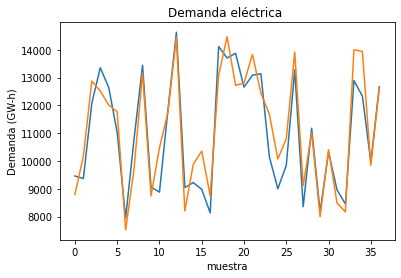

In [ ]:
import matplotlib.pyplot as plt

# graficamos el vector de salidas reales vs pronosticados
plt.title('Demanda eléctrica ')
plt.plot(lista)
#plt.plot(y)
# graficamos el valor real
plt.plot(y_test)
plt.xlabel('muestra')
plt.ylabel('Demanda (GW-h)')

Ahora crearemos una vista de los valores pronosticados y reales contra la secuencia que dió lugar a este valor. Usaremos esta función sencilla que aplicaremos más abajo.

In [ ]:
def create_time_steps(length):
    return list(range(-length, 0))

def show_plot(plot_data, title):
    labels = ['Historia', 'Verdadero Futuro', 'Predicción']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                     label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Pasos en tiempo')
    return plt


Aplicamos la función de graficación para que del conjunto de datos predichos obtenga la secuencia que predice y el valor real de demanda

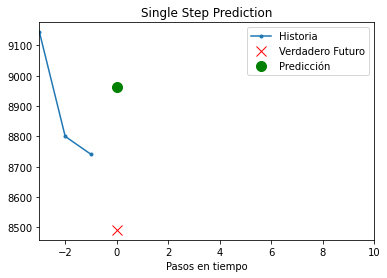

In [ ]:
# i_sample=5
i_sample = np.random.randint(len(y_test))   # Tomar un ejemplo aleatorio
x_sample = l[i_sample]
x_sample = x_sample.reshape((1, n_steps, n_features))
y_sample = y_test[i_sample]
yhat = model.predict(x_sample, verbose=0)

plot = show_plot([l[i_sample], y_sample, yhat], 'Single Step Prediction')

Calculamos el error medio absoluto porcentual (MAPE) para evaluar el modelo, el cual no es nada malo

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#mape=mean_absolute_percentage_error(lista, y)
mape=mean_absolute_percentage_error(lista, y_test)
print(mape)

6.501008212958719
